In [1]:
# 本案例是一个回归案例，根据输入特征通过多层网络返回一个预测值
# 矩阵计算
import numpy as np
# 数据基本处理
import pandas as pd 
# 画图
import matplotlib.pyplot as plt
# AI框架
import torch
# 优化器
import torch.optim as optim
# 日志处理工具
import warnings
warnings.filterwarnings("ignore")
# jupyter notebook 专属命令
%matplotlib inline

In [2]:
features = pd.read_csv('temps.csv')
# 数据结构
print(features.shape)
# 看看数据长什么样子
features.head()

(348, 9)


,year,month,day,week,temp_2,temp_1,average,actual,friend
0,2016,1,1,Fri,45,45,45.6,45,29
1,2016,1,2,Sat,44,45,45.7,44,61
2,2016,1,3,Sun,45,44,45.8,41,56
3,2016,1,4,Mon,44,41,45.9,40,53
4,2016,1,5,Tues,41,40,46.0,44,41


数据表中
* year,moth,day,week分别表示的具体的时间
* temp_2：前天的最高温度值
* temp_1：昨天的最高温度值
* average：在历史中，每年这一天的平均最高温度值
* actual：这就是我们的标签值了，当天的真实最高温度
* friend：这一列可能是凑热闹的，你的朋友猜测的可能值，咱们不管它就好了

In [3]:
# 348 个样本，每个样本 9 个属性
print('数据维度:', features.shape)

数据维度: (348, 9)


In [4]:
# 处理时间数据-时间数据格式化处理
import datetime

# 分别得到年，月，日
years = features['year']
months = features['month']
days = features['day']

# datetime格式
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

In [5]:
dates[:5]

[datetime.datetime(2016, 1, 1, 0, 0),
 datetime.datetime(2016, 1, 2, 0, 0),
 datetime.datetime(2016, 1, 3, 0, 0),
 datetime.datetime(2016, 1, 4, 0, 0),
 datetime.datetime(2016, 1, 5, 0, 0)]

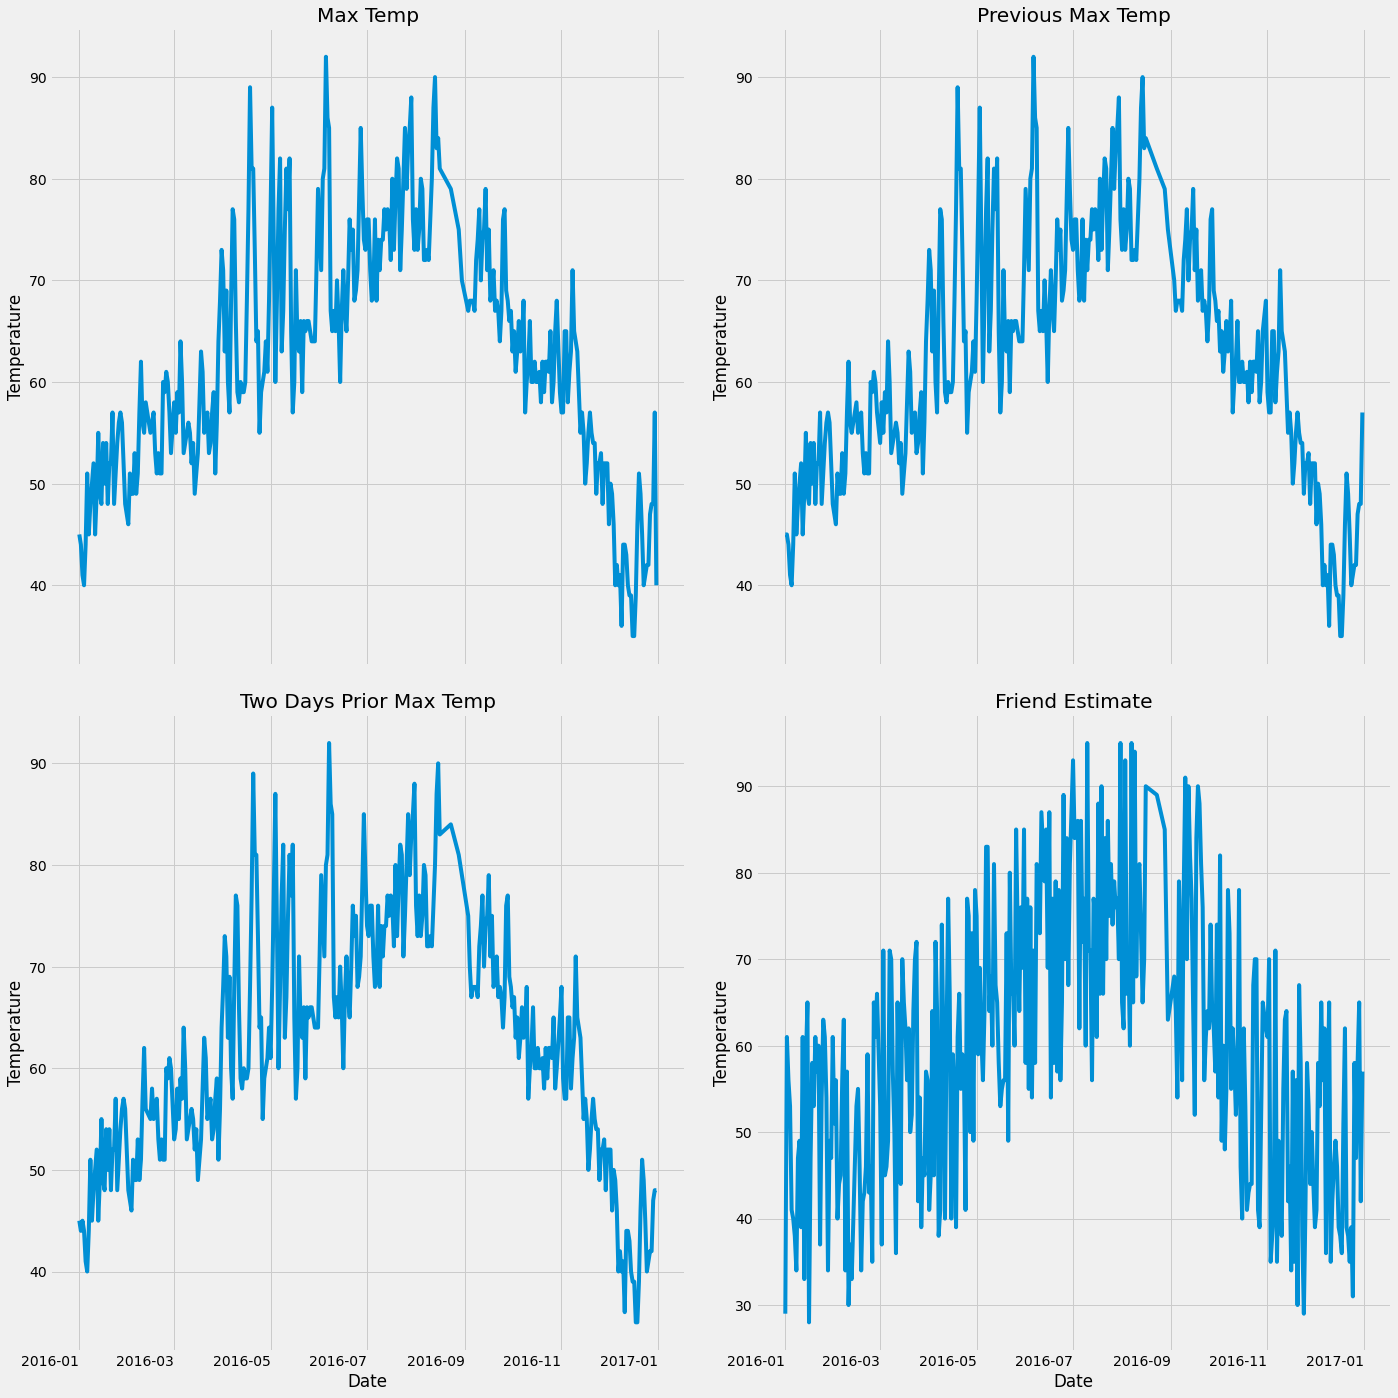

In [6]:
# 准备画图
# 指定默认风格
plt.style.use('fivethirtyeight')

# 设置布局
# subplots 代表子图显示格式-2行2列，figsize 用来控制图像尺寸大小
# ax1 ax2 ax3 ax4 代表四个子图
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (20,20))
# x 轴标签倾斜度
fig.autofmt_xdate(rotation = 0)

# 标签值
# plot 第一个参数是 x 轴，第二个参数是 y 轴
ax1.plot(dates, features['actual'])
ax1.set_xlabel(''); ax1.set_ylabel('Temperature'); ax1.set_title('Max Temp')

# 昨天
ax2.plot(dates, features['temp_1'])
ax2.set_xlabel(''); ax2.set_ylabel('Temperature'); ax2.set_title('Previous Max Temp')

# 前天
ax3.plot(dates, features['temp_2'])
ax3.set_xlabel('Date'); ax3.set_ylabel('Temperature'); ax3.set_title('Two Days Prior Max Temp')

# 我的逗逼朋友
ax4.plot(dates, features['friend'])
ax4.set_xlabel('Date'); ax4.set_ylabel('Temperature'); ax4.set_title('Friend Estimate')
# 设置每行每列间隔
plt.tight_layout(pad=2)

In [7]:
# 将 9 维数据变成 15 维数据（周一 到 周日共7维减去原本字符串周一到周日即新增6维）
# 即 7 维数据替换了原来的 week 数据
print(features.shape)
features = pd.get_dummies(features)
print(features.shape)
features.head(5)

(348, 9)
(348, 15)


,year,month,day,temp_2,temp_1,average,actual,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,29,1,0,0,0,0,0,0
1,2016,1,2,44,45,45.7,44,61,0,0,1,0,0,0,0
2,2016,1,3,45,44,45.8,41,56,0,0,0,1,0,0,0
3,2016,1,4,44,41,45.9,40,53,0,1,0,0,0,0,0
4,2016,1,5,41,40,46.0,44,41,0,0,0,0,0,1,0


In [8]:
# 标签
labels = np.array(features['actual'])

# 在特征中去掉标签
# 删掉 actual 列
# axis=0 代表行
# axis=1 代表列
features = features.drop('actual', axis = 1)

# 保存数据集的列名
feature_list = list(features.columns)
print(feature_list)

# 转换成合适的格式
features = np.array(features)

['year', 'month', 'day', 'temp_2', 'temp_1', 'average', 'friend', 'week_Fri', 'week_Mon', 'week_Sat', 'week_Sun', 'week_Thurs', 'week_Tues', 'week_Wed']


In [9]:
features.shape

(348, 14)

In [10]:
# 数据归一化、标准化
# 数据的有些标签天生比较大，而机器学习中值较大的数据具有优势，所以需要将数据归一化，即初始化各维数据的影响力为尽量相等
# preprocessing 为预处理模块
from sklearn import preprocessing
input_features = preprocessing.StandardScaler().fit_transform(features)

In [11]:
# 查看最后一条数据
input_features[347]

array([ 0.        ,  1.5810006 ,  1.76769198, -1.23020111, -0.47320122,
       -1.35658309, -0.19447185, -0.40961596, -0.40482045,  2.44131112,
       -0.40482045, -0.40482045, -0.41913682, -0.40482045])

### 构建网络模型

In [12]:
x = torch.tensor(input_features, dtype = float)

y = torch.tensor(labels, dtype = float)

# 权重参数随机初始化
# 每个数据 14 个特征，自定义第一个隐藏层 128 个神经元
w1 = torch.randn((14, 128), dtype = float, requires_grad = True) 
b1 = torch.randn(128, dtype = float, requires_grad = True) 
# 最后是输出一个预测值，所以为 1
w2 = torch.randn((128, 1), dtype = float, requires_grad = True) 
b2 = torch.randn(1, dtype = float, requires_grad = True) 
# 学习率-更新梯度值幅度大小的依据
learning_rate = 0.001 
losses = []

for i in range(1000):
    # 计算隐层
    hidden = x.mm(w1) + b1
    # 加入激活函数（不是直接乘第二层隐层，而是中间用激活函数）
    hidden = torch.relu(hidden)
    # 预测结果
    predictions = hidden.mm(w2) + b2
    # 通计算损失-均方误差
    loss = torch.mean((predictions - y) ** 2) 
    losses.append(loss.data.numpy())
    
    # 打印损失值
    if i % 100 == 0:
        print('损失函数:', loss)
    # 反向传播计算
    loss.backward()
    
    # 更新参数
    # *.grad.data 为本次反向传播之后更新的梯度值
    # 根据学习率和梯度值更新权重、微调参数
    # 注意：是沿着梯度的反方向去更新（因为要找的是什么样的权重参数可以使得损失值最低）
    w1.data.add_(- learning_rate * w1.grad.data)
    b1.data.add_(- learning_rate * b1.grad.data)
    w2.data.add_(- learning_rate * w2.grad.data)
    b2.data.add_(- learning_rate * b2.grad.data)
    
    # 每次迭代都得记得清空
    # 即之前的梯度与我们的下次计算时是没有关系的
    w1.grad.data.zero_()
    b1.grad.data.zero_()
    w2.grad.data.zero_()
    b2.grad.data.zero_()

损失函数: tensor(5103.3775, dtype=torch.float64, grad_fn=<MeanBackward0>)
损失函数: tensor(158.4374, dtype=torch.float64, grad_fn=<MeanBackward0>)
损失函数: tensor(148.5544, dtype=torch.float64, grad_fn=<MeanBackward0>)
损失函数: tensor(145.3931, dtype=torch.float64, grad_fn=<MeanBackward0>)
损失函数: tensor(143.8010, dtype=torch.float64, grad_fn=<MeanBackward0>)
损失函数: tensor(142.8174, dtype=torch.float64, grad_fn=<MeanBackward0>)
损失函数: tensor(142.1518, dtype=torch.float64, grad_fn=<MeanBackward0>)
损失函数: tensor(141.6655, dtype=torch.float64, grad_fn=<MeanBackward0>)
损失函数: tensor(141.2910, dtype=torch.float64, grad_fn=<MeanBackward0>)
损失函数: tensor(140.9911, dtype=torch.float64, grad_fn=<MeanBackward0>)


In [13]:
predictions.shape

torch.Size([348, 1])

### 更简单的构建网络模型

In [14]:
# input_features.shape[0] = 样本数
# input_features.shape[1] = 特征数
input_size = input_features.shape[1]
hidden_size = 128
output_size = 1
# 分批次迭代
batch_size = 16
# Sequential-序列模块
# 即按顺序执行
my_nn = torch.nn.Sequential(
    # Linear 为全连接层（权重参数已被自动初始化）
    torch.nn.Linear(input_size, hidden_size),
    # 激活函数
    torch.nn.Sigmoid(),
    # 输出
    torch.nn.Linear(hidden_size, output_size),
)
# 损失函数
# reduction 的三个值，none：不适用约简；mean：返回 loss 的平均值；sum：返回 loss 的和。默认：mean
cost = torch.nn.MSELoss(reduction='mean')
# 优化器
# 1 更新权重参数
# 2 指定学习率
# 3 Adam-提出了动量的概念，比 SGD 更优秀
optimizer = torch.optim.Adam(my_nn.parameters(), lr = 0.001)

In [25]:
print(my_nn)

Sequential(
  (0): Linear(in_features=14, out_features=128, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=128, out_features=1, bias=True)
)


In [39]:
# 训练网络
losses = []
for i in range(1000):
    batch_loss = []
    # MINI-Batch方法来进行训练
    # batch_size = 16
    # input_features = 348 个样本，每个样本 14 个特征
    # 从 0 到 384 循环，间隔为 16
    for start in range(0, len(input_features), batch_size):
        # 开始索引 + 间隔 = 最终索引
        end = start + batch_size if start + batch_size < len(input_features) else len(input_features)
        # 拿到测试样本
        x = torch.tensor(input_features[start:end], dtype = torch.float, requires_grad = True)
        # 拿到样本标签
        y = torch.tensor(labels[start:end], dtype = torch.float, requires_grad = True)
        # 拿到预训练网络
        pre_net = my_nn(x)
        # 损失函数
        loss = cost(pre_net, y)
        # 梯度归零
        optimizer.zero_grad()
        # 反向传播
        loss.backward(retain_graph=True)
        # 参数更新
        optimizer.step()
        # 根据学习率和梯度值更新权重、微调参数
        batch_loss.append(loss.data.numpy())
    
    # 打印损失
    if i % 100==0:
        losses.append(np.mean(batch_loss))
        print("损失函数：", np.mean(batch_loss))

损失函数： 29.715416
损失函数： 29.738146
损失函数： 29.729353
损失函数： 29.711037
损失函数： 29.715807
损失函数： 29.732075
损失函数： 29.738604
损失函数： 29.732891
损失函数： 29.723269
损失函数： 29.715986


预测训练结果

In [42]:
# 测试样本
x = torch.tensor(input_features, dtype = torch.float)
# 预测结果
# 转为 numpy 为了以后画图使用
predict = my_nn(x).data.numpy()

In [61]:
# 转换日期格式
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# 创建一个表格来存日期和其对应的标签数值
true_data = pd.DataFrame(data = {'date': dates, 'actual': labels})

# 同理，再创建一个来存日期和其对应的模型预测值
months = features[:, feature_list.index('month')]
days = features[:, feature_list.index('day')]
years = features[:, feature_list.index('year')]

test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
print(test_dates[0])
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]
print(test_dates[0])
# 预测值
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predict.reshape(-1)}) 
# 查看变量类型
# print(type(predictions_data))
# 查看第一行
# print(predictions_data.iloc[0])
# 查看第一行的某一列
print(predictions_data['prediction'].iloc[0])

2016-1-1
2016-01-01 00:00:00
47.284904


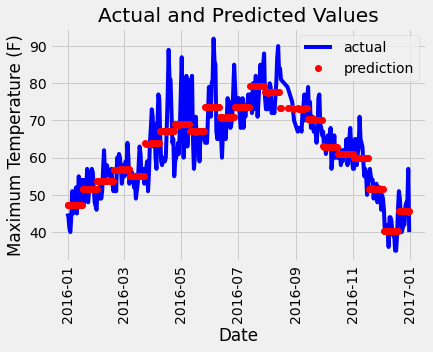

In [67]:
# 真实值-actual
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')

# 预测值-prediction
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
# x轴倾斜度
plt.xticks(rotation = '90'); 
# 显示 actual-——、prediction-.标签
plt.legend()

# 图名
plt.xlabel('Date'); 
plt.ylabel('Maximum Temperature (F)'); 
plt.title('Actual and Predicted Values');
